In [1]:
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, UpSampling2D, Reshape, Input, BatchNormalization, ZeroPadding2D
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import optimizers
from skimage.metrics import structural_similarity as ssim
from sklearn.feature_extraction import image
from sklearn.model_selection import train_test_split
import seaborn as sns;  sns.set()
from glob import glob
from tqdm import tqdm, trange
import numpy as np
import cv2
import os
import image_slicer
%matplotlib inline

In [2]:
bad_path = "C:\\Users\\dines\\Google Drive\\SensoViz\\Autoencoders\\Train Nok\\*.jpg"
train_path = "./storage/good/*.jpg"
files = glob(train_path)
fbad = glob(bad_path)
data = []
data_bad = []
for i in tqdm(files):
    data.append(cv2.imread(i,0).resize((320,320))/255)
for i in tqdm(fbad):
    data_bad.append(cv2.imread(i,0)/255)
data = np.asarray(data)
data_bad = np.asarray(data_bad)
data_bad = np.reshape(data_bad, (data_bad.shape[0], data_bad.shape[1], data_bad.shape[2], 1))
data = np.reshape(data, (data.shape[0], data.shape[1], data.shape[2], 1))

0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████| 2012/2012 [00:01<00:00, 1253.82it/s]


IndexError: tuple index out of range

In [ ]:
trainX, trainX, testX, testX = train_test_split(data, data, test_size=0.3)

In [ ]:
aug = ImageDataGenerator()
history = model.fit(aug.flow(data, data, batch_size=64), validation_data=(aug.flow(data, data)), steps_per_epoch=len(data) // 64, epochs=75, verbose=2)

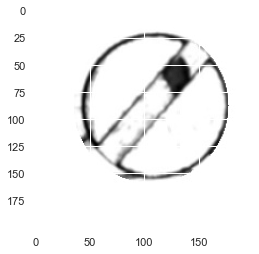

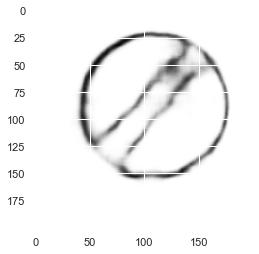

In [18]:
op = model.predict(data_bad[49].reshape(1,200,200,1))
plt.imshow(data_bad[49].reshape(200,200), cmap="gray")
plt.figure()
plt.imshow(op.reshape(200,200), cmap="gray")

In [43]:
def make_model(input_shape = (200,200,1)):
    input_img = Input(shape=input_shape)
    x = Conv2D(8, (5, 5), padding='same')(input_img)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(8, (5, 5), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(4, (5, 5), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    bflat = MaxPooling2D((2, 2), padding='same')(x)
    
    flat = Flatten()(bflat)
    
    x = Dense(1024)(flat)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dense(64)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Dense(flat.shape[1])(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Reshape((bflat.shape[1], bflat.shape[2], bflat.shape[3]))(x)
    
    x = Conv2D(4, (5, 5), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(8, (5, 5), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(8, (5, 5), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(input_shape[2], (5,5), padding="same")(x)
    
    model = Model(input_img, x)
    return model
m = make_model((200,200,1))
m.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 256, 256, 8)       608       
_________________________________________________________________
leaky_re_lu_130 (LeakyReLU)  (None, 256, 256, 8)       0         
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 128, 128, 8)       1608      
_________________________________________________________________
leaky_re_lu_131 (LeakyReLU)  (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 64, 64, 8)         0  

In [7]:
def load_model(name):
    json_file = open(name+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.load_weights(name+".h5")
    return model
def save_model(model, name):
    model_json = model.to_json()
    with open(name+".json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights(name+".h5")

In [8]:
model = load_model(r"C:\Users\dines\Google Drive\SensoViz\qualviz-dl\Anomaly Detection\Models\model")

In [11]:
def test(img,  patch_size, thresh):
    img = img.reshape(1,200,200,1)
    pred = model.predict(img)
    
    img_patches = split_image(img.reshape(200,200), patch_size)
    pred_patches = split_image(pred.reshape(200,200), patch_size)
    
    errs = []
    
    for i in range(len(img_patches)):
        errs.append((abs(pred_patches[i]-img_patches[i])))
    errs = np.asarray(errs)
    val = errs.mean() + 0.8*errs.std()
    op_arr = []
    for i in range(len(errs)):
        if(errs[i].mean()>=val):
            e = errs[i]
            e[e<=val] = img_patches[i][e<=val]
            op_arr.append(errs[i])
            #op_arr.append(np.full((patch_size, patch_size), 1))
        else:
            op_arr.append(img_patches[i])
    img = img
    rec = combine_image(op_arr)
    fin = np.stack((img.reshape((200,200)), img.reshape((200,200)), rec))
    
    return fin

(200, 200, 3)


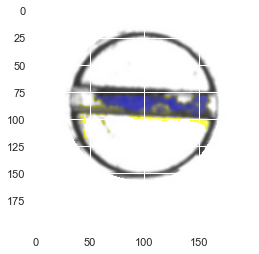

In [12]:
idx = 87
op = test(data_bad[idx],40, 20)
op = np.moveaxis(op, 0, -1)
img = data_bad[idx].reshape(200,200)

mask = op[:,:,2]
plt.imshow(op)
cv2.imwrite("og_good3.jpg", op*255)
# cv2.imwrite("overlay.jpg", op*255)
# cv2.imwrite("og.jpg", img*255)
print(op.shape)

In [52]:
def test(img, patch_size, thresh):
    img = img.reshape(1,200,200,1)
    pred = model.predict(img)
    
    img_patches = split_image(img.reshape(200,200), patch_size)
    pred_patches = split_image(pred.reshape(200,200), patch_size)
    errs = []
    for i in range(len(img_patches)):
        errs.append((abs(pred_patches[i]-img_patches[i])**2))
    errs = np.asarray(errs)
    op_arr = []
    for i in range(len(errs)):
        if(sum(sum(errs[i]))>=0):
            rect = 1-errs[i]
            op_arr.append(rect)
        else:
            op_arr.append(img_patches[i])
        
        
    img = img
    rec = combine_image(op_arr)
    fin = np.stack((img.reshape((200,200)), img.reshape((200,200)), rec))
    
    return fin

In [ ]:
idx

In [ ]:
for i in trange(len(data[:1000])):
    op = test(data[i],25, 10)*255
    op = np.moveaxis(op, 0, -1)
    cv2.imwrite("Good/"+str(i)+".jpg", op)

In [ ]:
def error(imageA, imageB):
    diff = imageA.astype("float") - imageB.astype("float")
    mse = np.sum(diff ** 2)
    mae = np.sum(abs(diff))
    mse /= float(imageA.shape[0] * imageA.shape[1])
    mae /= float(imageA.shape[0] * imageA.shape[1])
    struct = ssim(imageA.reshape(200,200), imageB.reshape(200,200))
    return [mse, mae, struct]

In [ ]:
def avg_err(data):
    res = []
    for i in tqdm(data):
        op = m.predict(i.reshape((1,200,200,1))).reshape(200,200)
        img = i.reshape((200,200))
        res.append(error(img, op))
    return(res)
    
err1 = avg_err(data[:1180])
err2 = avg_err(data_bad)

In [ ]:
arr1 = np.asarray(err1)
print(arr1.mean(axis=0))
print(arr1.max(axis=0))
print(arr1.min(axis=0))
print(arr1.ptp(axis=0))
print(arr1.std(axis=0))
print(arr1.var(axis=0))
print()
arr2 = np.asarray(err2)
print(arr2.mean(axis=0))
print(arr2.max(axis=0))
print(arr2.min(axis=0))
print(arr2.ptp(axis=0))
print(arr2.std(axis=0))
print(arr2.var(axis=0))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
#
x1 = arr1[:, 0]
x2 = arr2[:, 0]
a = plt.boxplot([x1, x2], showmeans=True, meanline=True, labels=["Good Samples", "Defective Samples"], widths=0.5)
plt.title("Box Plot of MSE")
for line in a['medians']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    text(x, y, '%.4f' %y,
         horizontalalignment='left', verticalalignment='center')
for line in a['means']:
    # get position data for median line
    x, y = line.get_xydata()[0] # top of median line
    # overlay median value
    text(x, y, '%.4f' %y,
         horizontalalignment='right', verticalalignment='center')
plt.savefig('mse_box.png', dpi=400, bbox_inches='tight')


plt.clf()
x1 = arr1[:, 1]
x2 = arr2[:, 1]
b = plt.boxplot([x1, x2], showmeans=True, meanline=True, labels=["Good Samples", "Defective Samples"], widths=0.5)
plt.title("Box Plot of MAE")
for line in b['medians']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    text(x, y, '%.4f' %y,
         horizontalalignment='left', verticalalignment='center')
for line in b['means']:
    # get position data for median line
    x, y = line.get_xydata()[0] # top of median line
    # overlay median value
    text(x, y, '%.4f' %y,
         horizontalalignment='right', verticalalignment='center')
plt.savefig('mae_box.png', dpi=400, bbox_inches='tight')

plt.clf()
x1 = arr1[:, 2]
x2 = arr2[:, 2]
c = plt.boxplot([x1, x2], showmeans=True, meanline=True, labels=["Good Samples", "Defective Samples"], widths=0.5)
plt.title("Box Plot of SSIM")
for line in c['medians']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    text(x, y, '%.4f' %y,
         horizontalalignment='left', verticalalignment='center')
for line in c['means']:
    # get position data for median line
    x, y = line.get_xydata()[0] # top of median line
    # overlay median value
    text(x, y, '%.4f' %y,
         horizontalalignment='right', verticalalignment='center')
plt.savefig('ssim_box.png', dpi=400, bbox_inches='tight')
plt.show()



In [3]:
def split_image(img, window_size):
    patches = []
    ctr = 0
    for r in range(0, img.shape[0], window_size):
        for c in range(0, img.shape[0], window_size):
            patches.append(img[r:min(img.shape[0],r+window_size), c:min(img.shape[0], c+window_size)])
            ctr+=1
    patches = np.asarray(patches)
    return patches

def combine_image(patches):
    rows = cols = int(np.sqrt(len(patches)))
    img = np.asarray([])
    for i in range(cols):
        row = patches[i*cols]
        for j in range (1, rows):
            row = np.concatenate((row, patches[i*cols+j]), axis = 1)
        img = np.vstack([img, row]) if img.size else row
    return img

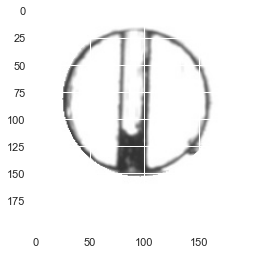

<Figure size 432x288 with 0 Axes>

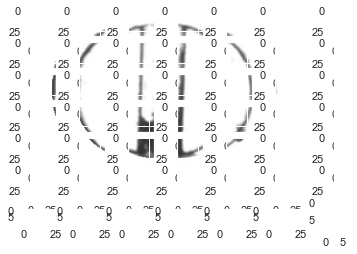

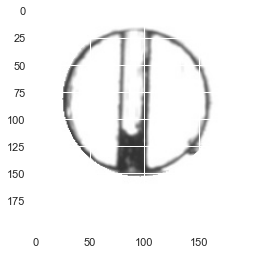

In [5]:
def draw_patches(patches):
    plt.figure()
    no_of_patches = len(patches)
    fig, ax = plt.subplots(nrows=int(np.sqrt(no_of_patches)), ncols=int(np.sqrt(no_of_patches)))
    ctr = 0
    for row in ax:
        for col in row:
            col.imshow(patches[ctr], cmap="gray")
            ctr+=1
    
#img = data_bad[0].reshape(200,200)
img = cv2.imread("C:\\Users\\dines\\Google Drive\\SensoViz\\Autoencoders\\Train Nok\\478.jpg")

plt.imshow(img, cmap="gray")
patches = split_image(img, 32)
draw_patches(patches)
recombined = combine_image(patches)
plt.figure()
plt.imshow(recombined, cmap="gray")
plt.show()

# The black patches in the second image are not actually black it's just matplotlib handling the data really badly. 